<a href="https://colab.research.google.com/github/datasolut/tutorials/blob/master/Churn_Prediction_Tutorial_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Churn Prediction Tutorial

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set(style='white')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1) Datenvorverarbeitung

### 1.1) Die Daten

Beispieldatensatz "Telco-Customer-Churn" zu finden bei Kaggle (https://www.kaggle.com/blastchar/telco-customer-churn) oder bei Github: (https://github.com/IBM/telco-customer-churn-on-icp4d/blob/master/data/Telco-Customer-Churn.csv)

In [ ]:
url = 'https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv'
df = pd.read_csv(url)

### 1.1) Datenexploration

In [ ]:
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Churn
No     0.73463
Yes    0.26537
dtype: float64


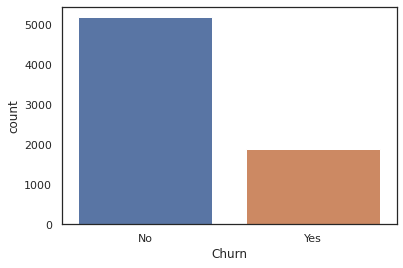

In [ ]:
sns.countplot(x='Churn', data=df);
print(df.groupby('Churn').size()/len(df))

### 1.3) Datenaufbereitung und Feature Engineering

In [ ]:
# Kundennummer löschen
df = df.drop(['customerID'], axis=1)

In [ ]:
# TotalCharges hat Leerzeichen in der Variable, diese müssen wir löschen und mit NULL-Werten ersetzen.
df['TotalCharges'] = df["TotalCharges"].replace(" ",np.nan)

# Wir löschen die Daten mit fehlenden Werten
df = df.dropna(subset=['TotalCharges'])

In [ ]:
# Datentypen änderen
df["TotalCharges"] = df["TotalCharges"].astype(float)

In [ ]:
# Dummy-Variablen erstellen
telcom = pd.get_dummies(df, df.loc[:, df.dtypes == np.object].columns, drop_first = True )
telcom.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
0,0,1,29.85,29.85,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1,0,34,56.95,1889.50,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
2,0,2,53.85,108.15,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1
3,0,45,42.30,1840.75,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0
4,0,2,70.70,151.65,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1


In [ ]:
from sklearn.model_selection import train_test_split

# Zielvariable und Prädiktoren trennen
y = telcom["Churn_Yes"].to_numpy()
X = telcom.drop(labels = ["Churn_Yes"],axis = 1)

# Daten in Train und Test Set aufteilen
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## 2) Modellierung

### 2.1) Modell-Training

In [ ]:
from sklearn.linear_model import LogisticRegression
model_ = LogisticRegression(max_iter=100, solver='liblinear')
model_.fit(X_train, y_train);

### 2.2) Modell-Validierung

In [ ]:
# Vorhersage auf Testdaten
prediction_test = model_.predict(X_test)
prediction_probas = model_.predict_proba(X_test)[:,1]

In [ ]:
from sklearn import metrics

# Accuracy Score
acc = metrics.accuracy_score(y_test, prediction_test)
print('Accuracy on test set: {}'.format(acc))

In [ ]:
# ROC Curve, AUC
fig, ax = plt.subplots(figsize=(8,6))
ax.set_title('Receiver Operating Curve')
plot = metrics.plot_roc_curve(model_, X_test, y_test, ax=ax);
ax.plot([0,1], [0,1], '--');

## 3) Verwendung für Churn Prevention und Churn Analyse

In [ ]:
# Computations for lift chart
df = pd.DataFrame({'pred_proba':prediction_probas, 'true_label':y_test})
df['pred_decile'] = pd.qcut(df['pred_proba'],10,labels=np.arange(10,0,-1)).astype(object)

lift = df.groupby('pred_decile').agg({'true_label': ['count','sum', 'mean']}).sort_index().reset_index()
lift.columns = ['pred_decile', 'n', 'pos_label', 'perc_pos_label']
lift['overall_perc_pos_label'] = df['true_label'].mean()
lift[['n_cum', 'pos_label_cum']] = lift[['n', 'pos_label']].cumsum()
lift['perc_pos_label_cum'] = lift['pos_label_cum']/lift['n_cum']
lift['baseline'] = 1
lift['lift'] = lift['perc_pos_label']/lift['overall_perc_pos_label']
lift['cumulative lift'] = lift['perc_pos_label_cum']/lift['overall_perc_pos_label']

In [ ]:
# plot lift chart
lift.plot(x='pred_decile', y=['lift', 'cumulative lift', 'baseline'], figsize=(12,6));

In [ ]:
# Regressionskoeffizienten auslesen
weights = pd.Series(model_.coef_[0],
 index=X.columns.values)
weights.sort_values(ascending = False)

In [ ]:
# Confusion Matrix
#conf = metrics.confusion_matrix(y_test, prediction_test)
#pd.DataFrame(data=conf, columns=['predicted_0', 'predicted_1'], index=['true_0', 'true_1'])